https://www.kaggle.com/code/strawhatsai/analysis-of-obesity-dataset-using-h2o-automl/notebook
# Introduction


In this notebook we will be exploring Linear regression on the obesity dataset with Age as the independent variable 

Also, we will explore Logistic regression and random forest regression using Obesity category as the independent variable

In [1]:
# Setting up h20
! pip install h2o
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.17" 2022-10-18; OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu220.04); OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu220.04, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp_q84hjug
  JVM stdout: /tmp/tmp_q84hjug/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp_q84hjug/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.3
H2O_cluster_version_age:,"1 year, 10 months and 14 days !!!"
H2O_cluster_name:,H2O_from_python_unknownUser_cov9fp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.500 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [3]:
# Required headers
%matplotlib inline
import random, os, sys
import seaborn as sns
import pandas
import pprint
import operator
import matplotlib
from tabulate import tabulate
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np


In [22]:
# set this to True if interactive (matplotlib) plots are desired
interactive = True
if not interactive: matplotlib.use('Agg', warn=False)
import matplotlib.pyplot as plt


In [23]:
print("Import and Parse data")
url = "https://raw.githubusercontent.com/detective-sokka/Skunks_Skool/detective-sokka-obesity-dataset/Obesity%20Data.csv"
data = h2o.import_file(path=url) # import from url
data.describe()


Import and Parse data

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:2111
Cols:17

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
type,enum,real,real,real,enum,enum,real,real,enum,enum,real,enum,real,real,enum,enum,enum
mins,,14.0,1.45,39.0,,,1.0,1.0,,,1.0,,0.0,0.0,,,
mean,,24.312599908574136,1.70167735338702,86.58605812648035,,,2.419043061582188,2.68562804973946,,,2.0080114040738986,,1.0102976958787304,0.657865923732828,,,
maxs,,61.0,1.98,173.0,,,3.0,4.0,,,3.0,,3.0,2.0,,,
sigma,,6.345968273732233,0.0933048198679201,26.191171745204695,,,0.5339265785033002,0.7780386488418612,,,0.6129534517968723,,0.8505924308366978,0.6089272596763782,,,
zeros,,0,0,0,,,0,0,,,0,,411,557,,,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Not_Obese
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Not_Obese
2,Male,23.0,1.8,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Not_Obese


In [24]:
# split into training and test for cross vāalidation
train, test = data.split_frame([0.7], seed = 1)

In [25]:
# assign target and inputs for logistic regression
y = 'NObeyesdad'
X = [name for name in data.columns if name != y]
print(y)
print(X)

NObeyesdad

['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS']


In [26]:
# assign target and inputs for linear regression
# setting age as the independent variable

y_age = 'Age'
X_age = [name for name in data.columns if name != y_age]
print(y_age)
print(X_age)

Age

['Gender', 'Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'NObeyesdad']


In [27]:
# Build simple GLM model
run_time=333

# Running linear regression
data_reg = H2OAutoML(max_runtime_secs=run_time, max_models = 1, include_algos = ["GLM"])

data_reg.train(x               = X_age,
               y               = y_age,
               training_frame  = train,
               validation_frame= test)


AutoML progress: |

17:28:08.669: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.



███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_1_AutoML_3_20230116_172808


GLM Model: summary
    family    link      regularization               lambda_search                                                                   number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  ---------------------------  ------------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  ------------------------------------------------
    gaussian  identity  Ridge ( lambda = 0.008618 )  nlambda = 30, lambda.max = 190.65, lambda.min = 0.008618, lambda.1se = 0.05794  32                            32                             22                      AutoML_3_20230116_172808_training_py_56_sid_aab2

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 19.10047308716694
RMSE: 4.370408800920909
MAE: 3.0879795489773127
RMSLE: 0.15907366622536553
Mean Residual Deviance: 19.10047308716694
R^2: 0.5229815725200273
Null degrees of freedom: 1494
Residual degrees of freedom: 1462
Null deviance: 59861.853589532344
Residual deviance: 28555.207265314573
AIC: 8720.447304324622

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 21.779133573132228
RMSE: 4.666811928193831
MAE: 3.3218869718958572
RMSLE: 0.171377470911805
Mean Residual Deviance: 21.779133573132228
R^2: 0.4635928884272511
Null degrees of freedom: 615
Residual degrees of freedom: 583
Null deviance: 25151.76656953097
Residual deviance: 13415.946281049453
AIC: 3713.9989118013737

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 19.79124200217924
RMSE: 4.448734876588988
MAE: 3.132304311938812
RMSLE: 0.1618151305237954
Mean Residual Deviance: 19.79124200217924
R^2: 0.5057301934527495
Null degrees of freedom: 1494
Residual degrees of freedom: 1462
Null deviance: 59907.442709172814
Residual deviance: 29587.90679325796
AIC: 8773.559291785099

Cross-Validation Metrics Summary: 
                        mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------
mae                     3.13183   0.168431    3.30383       2.86842       3.2474        3.09899       3.1405
mean_residual_deviance  19.714    2.60213     21.7515       16.0846       19.3352       18.7402       22.6583
mse                     19.714    2.60213     21.7515       16.0846       19.3352       18.7402       22.6583
null_deviance           11981.5   1024.23     10888.9       10857.8       12687.9       12511.4       12961.3
r2                      0.505707  0.0664953   0.401705      0.556599      0.542408      0.551319      0.476507
residual_deviance       5894.48   778.035     6503.68       4809.31       5781.23       5603.31       6774.84
rmse                    4.43213   0.296148    4.66385       4.01057       4.39718       4.32899       4.76008
rmsle                   0.161463  0.00805224  0.172214      0.150356      0.162566      0.158014      0.164165

Scoring History: 
     timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test       deviance_xval       deviance_se         alpha    iterations    training_rmse      training_deviance    training_mae        training_r2         validation_rmse    validation_deviance    validation_mae      validation_r2
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------  ------------------  ------------------  -------  ------------  -----------------  -------------------  ------------------  ------------------  -----------------  ---------------------  ------------------  ------------------
     2023-01-16 17:28:10  0.000 sec   1            .19E3     33            3

In [28]:
print(data_reg.leaderboard)
glm_regularized = h2o.get_model(data_reg.leaderboard[0,'model_id'])

model_id                           rmse      mse     mae     rmsle    mean_residual_deviance

GLM_1_AutoML_3_20230116_172808  4.44873  19.7912  3.1323  0.161815                   19.7912

[1 row x 6 columns]




In [29]:
# Define model binary classification
data_bin_class = H2OAutoML(max_runtime_secs=run_time, max_models = 2, include_algos = ["DRF", "GLM"])

# Train model
data_bin_class.train(x=X, y=y, training_frame=train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_1_AutoML_4_20230116_172812


GLM Model: summary
    family    link    regularization              lambda_search                                                                  number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  --------------------------  -----------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  ------------------------------------------------
    binomial  logit   Ridge ( lambda = 3.96E-5 )  nlambda = 30, lambda.max = 39.604, lambda.min = 3.96E-5, lambda.1se = 3.96E-5  31                            31                             77                      AutoML_4_20230116_172812_training_py_56_sid_aab2

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.0023976428428377234
RMSE: 0.048965731311170296
LogLoss: 0.013326428084761
AUC: 0.9999694186301705
AUCPR: 0.9999655233198069
Gini: 0.999938837260341
Null degrees of freedom: 1494
Residual degrees of freedom: 1463
Null deviance: 2064.8453242291585
Residual deviance: 39.84601997343539
AIC: 103.84601997343539

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5192185952614189
           Not_Obese    Obese    Error    Rate
---------  -----------  -------  -------  ------------
Not_Obese  801          0        0        (0.0/801.0)
Obese      1            693      0.0014   (1.0/694.0)
Total      802          693      0.0007   (1.0/1495.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.519219     0.999279  184
max f2                       0.519219     0.998847  184
max f0point5                 0.519219     0.999711  184
max accuracy                 0.519219     0.999331  184
max precision                1            1         0
max recall                   0.142303     1         202
max specificity              1            1         0
max absolute_mcc             0.519219     0.998656  184
max min_per_class_accuracy   0.519219     0.998559  184
max mean_per_class_accuracy  0.519219     0.99928   184
max tns                      1            801       0
max fns                      1            266       0
max fps                      8.28481e-08  801       399
max tps                      0.142303     694       202
max tnr                      1            1         0
max fnr                      1            0.383285  0
max fpr                      8.28481e-08  1         399
max tpr                      0.142303     1         202

Gains/Lift Table: Avg response rate: 46.42 %, avg score: 46.42 %
group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  -------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------  --------------------
1        0.0287625                   1                  2.15418  2.15418            1                1            1                           1                   0.0619597       0.0619597                  115.418  115.418            0.0619597
2        0.0535117                   1                  2.15418  2.15418            1                1            1                           1                   0.0533141       0.115274                   115.418  115.418            0.115274
3        0.100334                    1                  2.15418  2.15418            1                1            1                           1      

In [30]:
print(data_bin_class.leaderboard)

best_bin_class = h2o.get_model(data_bin_class.leaderboard[0,'model_id'])

rand_for = best_bin_class

model_id                             auc    logloss     aucpr    mean_per_class_error       rmse         mse

GLM_1_AutoML_4_20230116_172812  0.9998    0.0209078  0.999783               0.0027856  0.0694772  0.00482708

DRF_1_AutoML_4_20230116_172812  0.999404  0.0640094  0.999322               0.0106612  0.114728   0.0131626

[2 rows x 7 columns]




# Is the relationship significant?



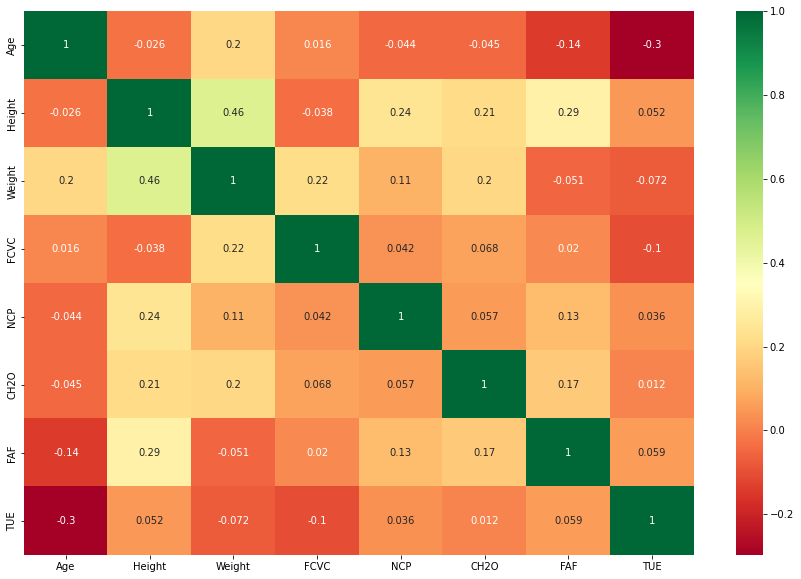

In [31]:
data_as_df = h2o.as_list(data)
plt.figure(figsize=(15,10))
sns.heatmap(data_as_df.corr(), annot = True, cmap='RdYlGn') 

From the heat map we see that there seems to be a strong correlation between Weight and Obesity level which is to be expected. Moreover there is an inverse correlation between height and gender. 

Age (being the independent variable for linear regression) does not seem to have any significant relationship with other variables

# Are any model assumptions violated?


In the case of GLM the model assumptions are linearity, homoskedasticity (constant variance), normality, and independence. 

We can measure the same from the above and using the correlation matrix. Hence we can assume that the model assumptions are reasonably followed

In the case of random forest classifier, the assunptions are that the input data is continuous, and the target variable is discrete

We see from the data and the correlation matrix that this is true. 

# Is there any multi-collinearity in the model?

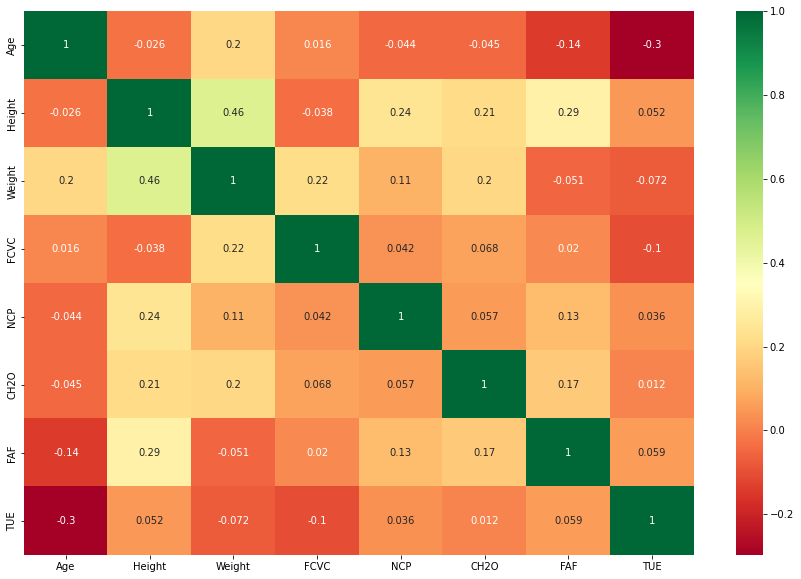

In [32]:
data_as_df = h2o.as_list(data)
plt.figure(figsize=(15,10))
sns.heatmap(data_as_df.corr(), annot = True, cmap='RdYlGn') 

From the heatmap we see that the variables are fairly independent of each other

# In multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.



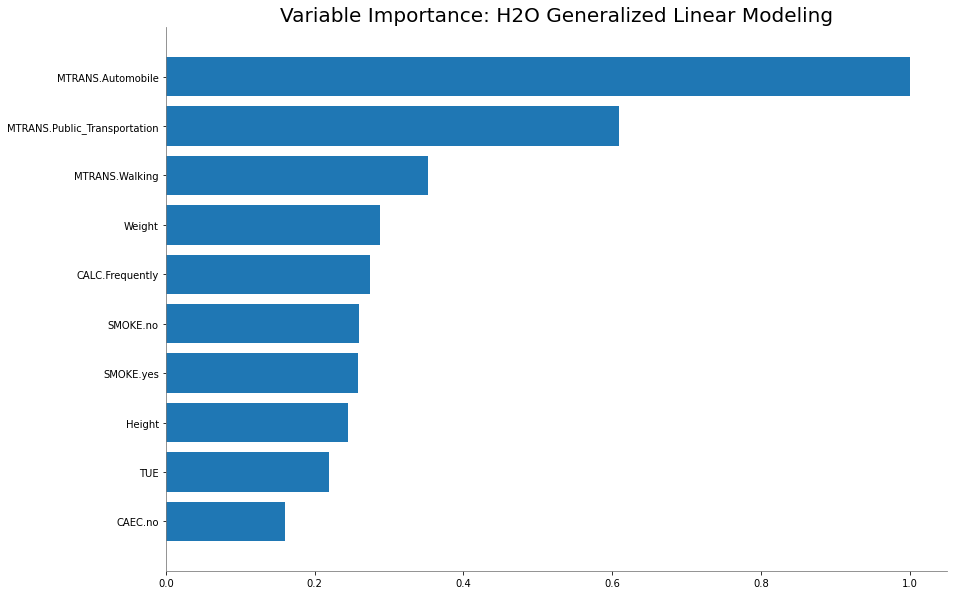

<Figure size 432x288 with 0 Axes>

In [33]:
glm_regularized.varimp_plot()

In the case of linear regression where the independent variable is age, mode of transportation seems to be the most effective predictor of someones age. 

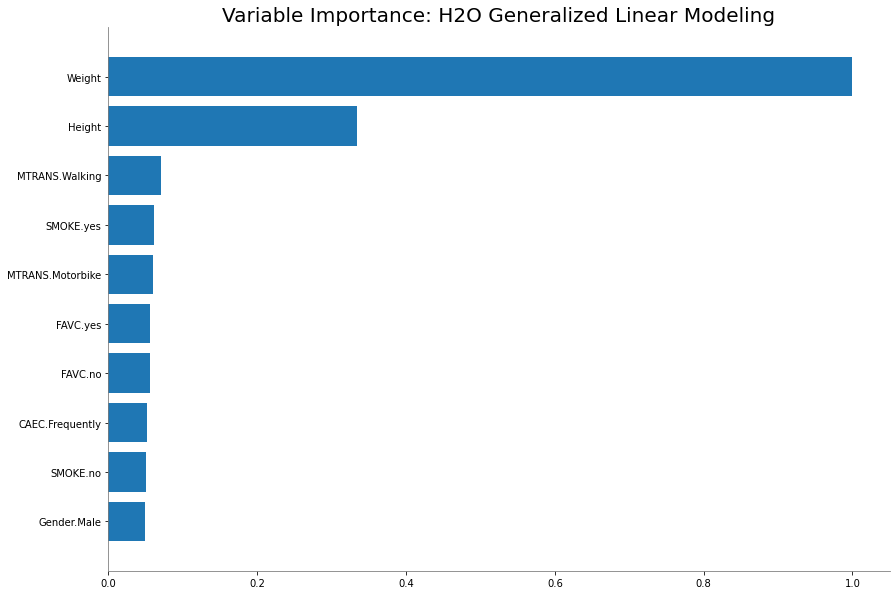

<Figure size 432x288 with 0 Axes>

In [34]:
best_bin_class.varimp_plot()

In the case of logistic regression where we are predicting obesity, weight and height seem to be the major predictors which is not surprising

# Does the model make sense?
 


## Binary classification




# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GLM_1_AutoML_4_20230116_172812

,Not_Obese,Obese,Error,Rate
Not_Obese,338.0,0.0,0.0,(0.0/338.0)
Obese,2.0,276.0,0.0072,(2.0/278.0)
Total,340.0,276.0,0.0032,(2.0/616.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

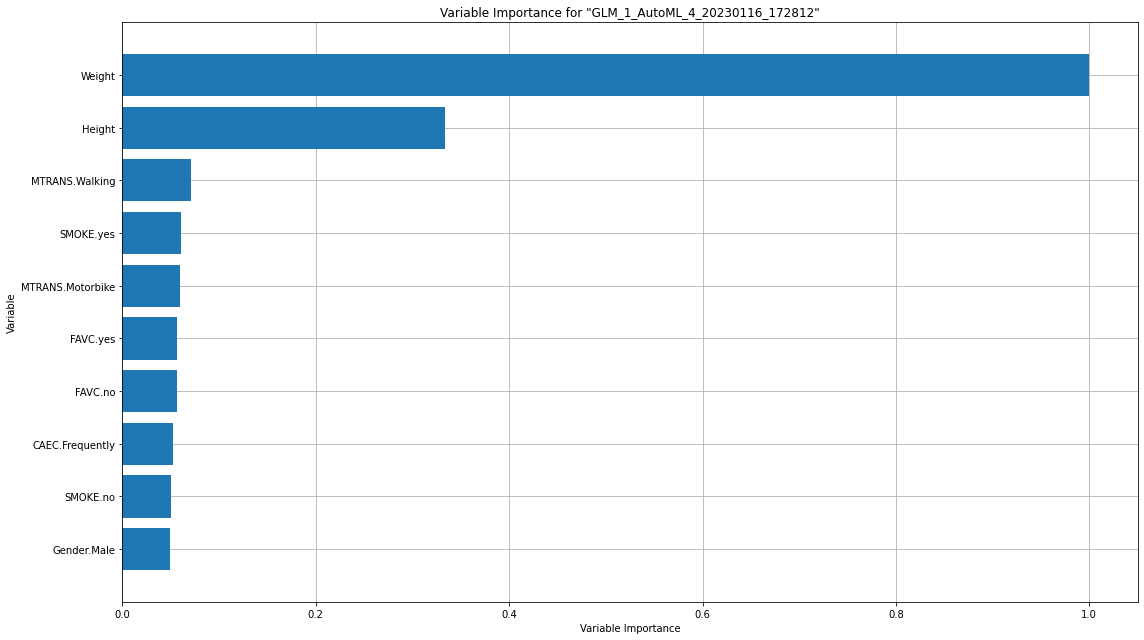

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

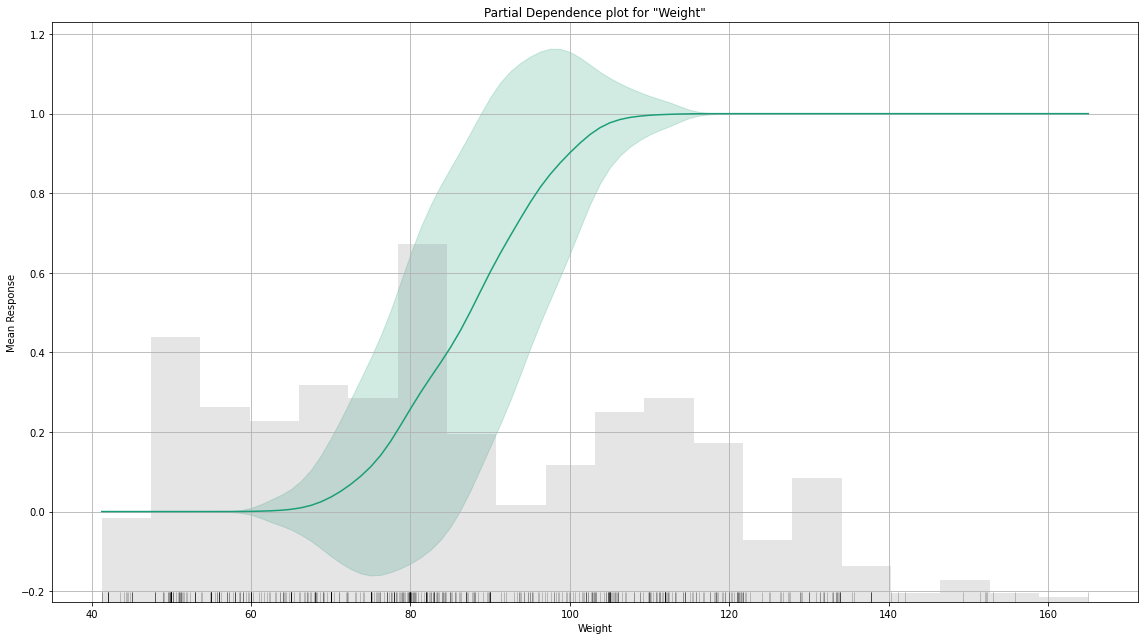

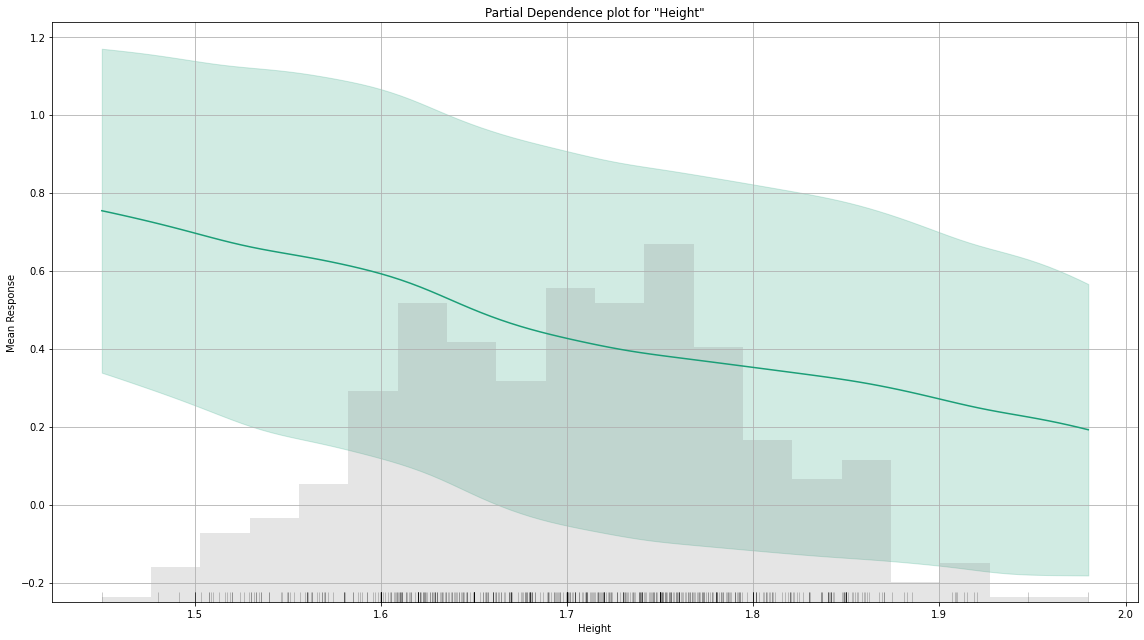

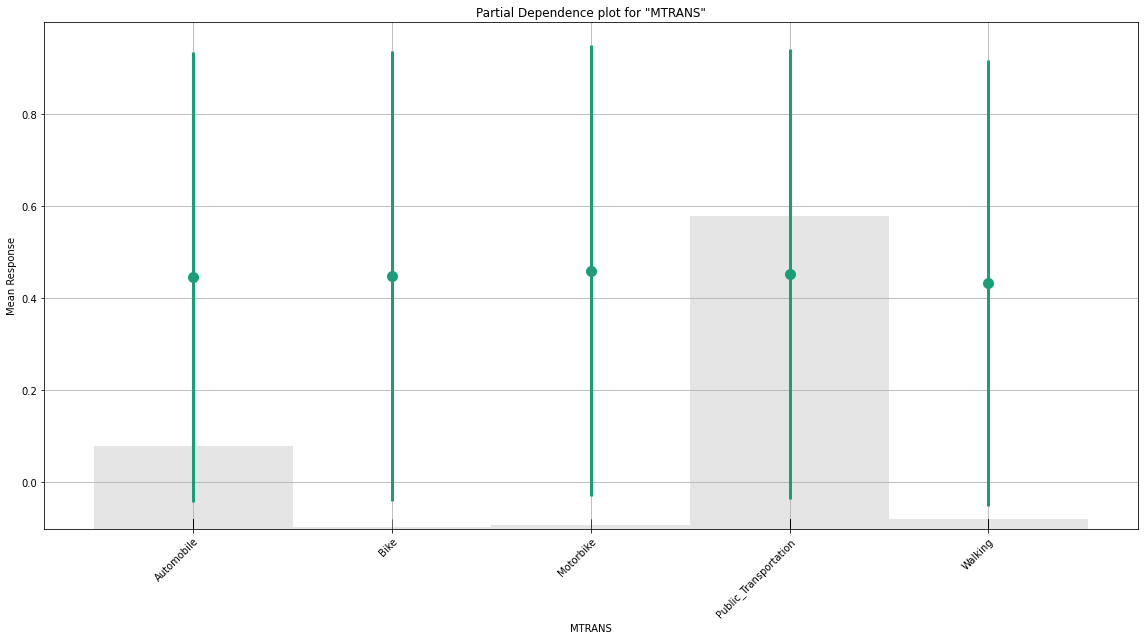

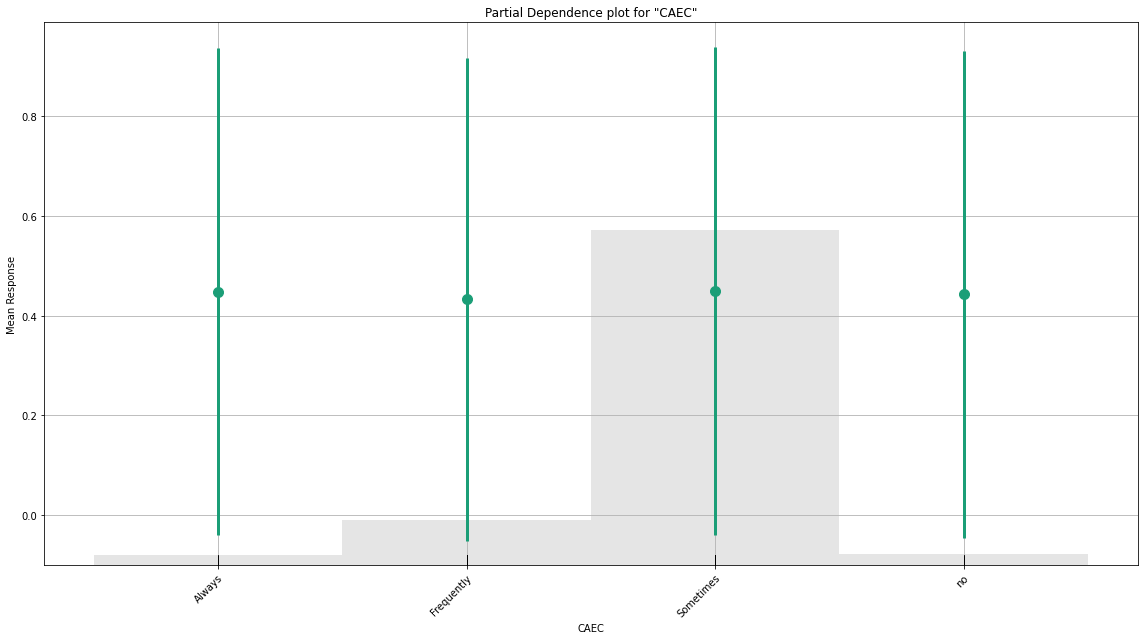

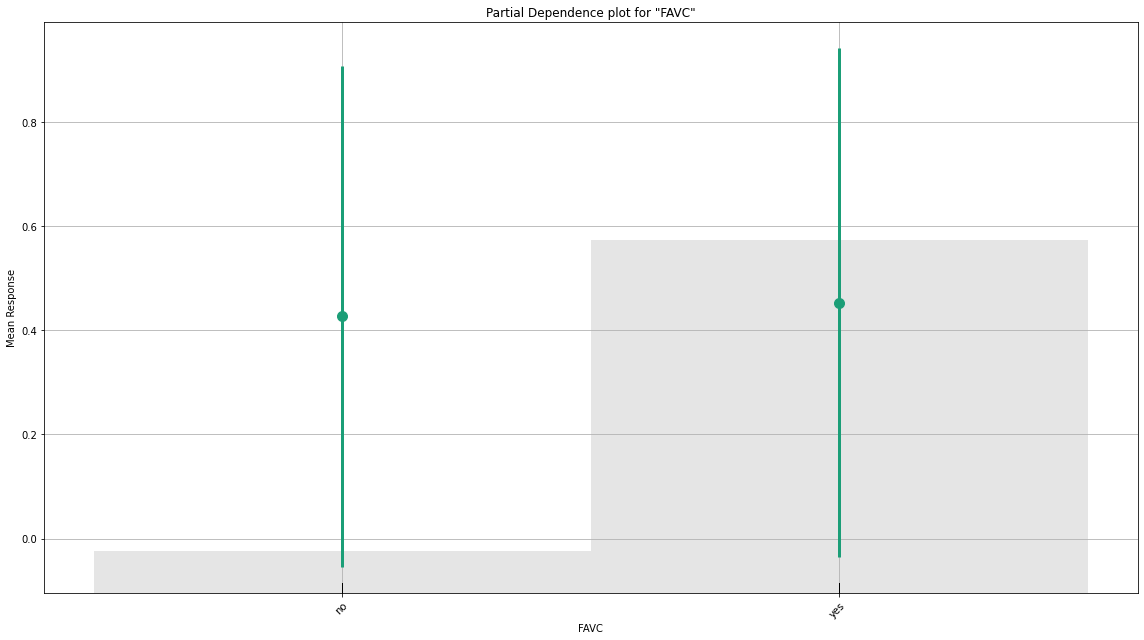

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GLM_1_AutoML_4_20230116_172812

,Not_Obese,Obese,Error,Rate
Not_Obese,338.0,0.0,0.0,(0.0/338.0)
Obese,2.0,276.0,0.0072,(2.0/278.0)
Total,340.0,276.0,0.0032,(2.0/616.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

In [35]:
best_bin_class.explain(test)

## Regression

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

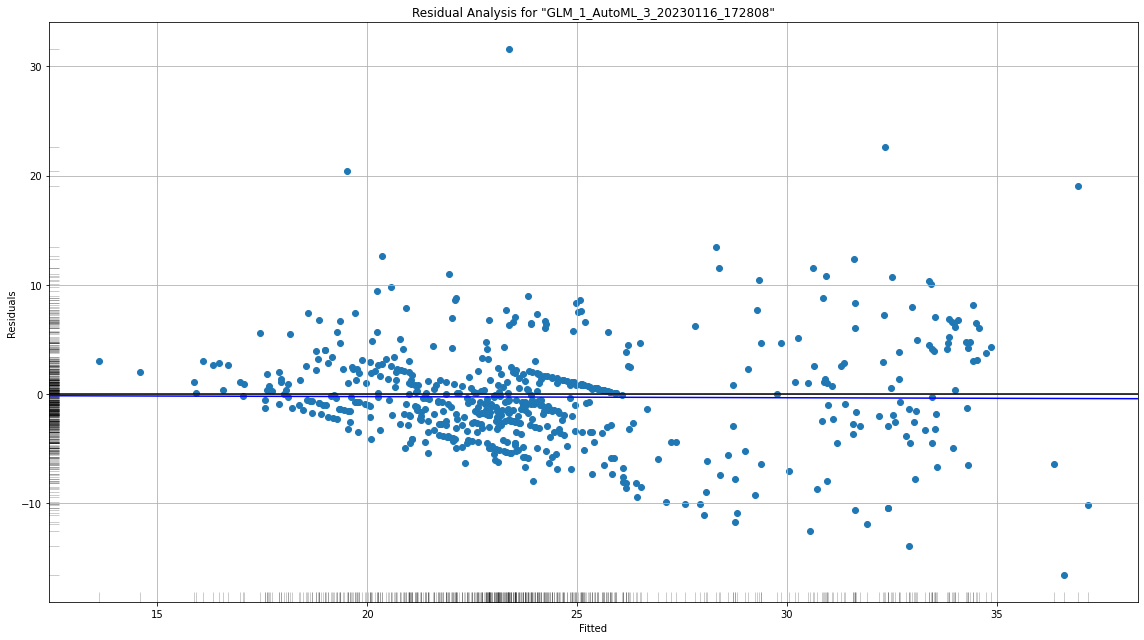

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

In [36]:
glm_regularized.explain(test, include_explanations=["residual_analysis", "model_correlation_heatmap"])


# Does regularization help?

## Linear regression

Running linear regression once again without regularization to compare the test results 

In [37]:
data_wo_reg = H2OGeneralizedLinearEstimator(family="gaussian", standardize=True, lambda_= 0)
data_wo_reg.train(x  = X_age,
                  y  = y_age,
                  training_frame  = train,
                  validation_frame=test)
print("Completed")

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%

Completed


In [38]:
print("Without regularization : \n")
print(data_wo_reg.model_performance(test))

print("With Reg : \n ")
print(glm_regularized.model_performance(test))

Without regularization : 



ModelMetricsRegressionGLM: glm

** Reported on test data. **



MSE: 21.90914476591118

RMSE: 4.680720539181033

MAE: 3.3243447387551233

RMSLE: 0.17217768177748066

Mean Residual Deviance: 21.90914476591118

R^2: 0.4603907900445716

Null degrees of freedom: 615

Residual degrees of freedom: 592

Null deviance: 25151.76656953097

Residual deviance: 13496.033175801287

AIC: 3699.6652101409345

With Reg : 

 

ModelMetricsRegressionGLM: glm

** Reported on test data. **



MSE: 21.779133573132228

RMSE: 4.666811928193831

MAE: 3.3218869718958572

RMSLE: 0.171377470911805

Mean Residual Deviance: 21.779133573132228

R^2: 0.4635928884272511

Null degrees of freedom: 615

Residual degrees of freedom: 583

Null deviance: 25151.76656953097

Residual deviance: 13415.946281049453

AIC: 3713.9989118013737


Comparing the MSE and other values see that the performance is improved. 

## Classification

In [39]:
data_class_wo_reg = H2OGeneralizedLinearEstimator(family="binomial", standardize=True, lambda_=0)
data_class_wo_reg.train(x  = X,
                  y  = y,
                  training_frame  = train,
                  validation_frame=test)
print("Completed")

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%

Completed


/usr/local/lib/python3.8/dist-packages/h2o/job.py:83: UserWarning: Reached maximum number of iterations 50!

  warnings.warn(w)


In [40]:
print("Without regularization : \n")
print(data_class_wo_reg.model_performance(test))

print("\n With Regularization : \n ")
print(best_bin_class.model_performance(test))

Without regularization : 



ModelMetricsBinomialGLM: glm

** Reported on test data. **



MSE: 0.0058085042473165595

RMSE: 0.07621354372627322

LogLoss: 0.08337534020366383

AUC: 0.9983983227619088

AUCPR: 0.9961946611061222

Gini: 0.9967966455238175

Null degrees of freedom: 615

Residual degrees of freedom: 592

Null deviance: 848.5175802761421

Residual deviance: 1450.4337034056205

AIC: 1498.4337034056205



Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9979407917579577

           Not_Obese    Obese    Error    Rate

---------  -----------  -------  -------  -----------

Not_Obese  336          2        0.0059   (2.0/338.0)

Obese      1            277      0.0036   (1.0/278.0)

Total      337          279      0.0049   (3.0/616.0)



Maximum Metrics: Maximum metrics at their respective thresholds

metric                       threshold    value      idx

---------------------------  -----------  ---------  -----

max f1                       0.997941     0.994614   9



We see comparing the above MSE and AUC values that regularization improves the performance

# Which hyperparameters are important?

Linear regression and logistic regression have the parameter lambda which sets the regularization as the hyperparameter

In [41]:
glm_regularized.summary()['regularization'] # with regularization

['Ridge ( lambda = 0.008618 )']

In [43]:
data_wo_reg.summary()['regularization'] # No regularization

['None']

# References

1. https://towardsdatascience.com/visualizing-large-datasets-with-h2o-ffe9af40371b
2. https://github.com/aiskunks/Skunks_Skool/blob/defb7f682b010292e6e77666e2ef4bd451dfa5fd/H2O_AutoML_IPYNB/penalized_logistic_regression-checkpoint.ipynb
3. https://github.com/aiskunks/Skunks_Skool/blob/main/INFO_6105/6105/6105_H2O_automl_lending_club.ipynb
4. https://medium.com/tech-vision/random-forest-classification-with-h2o-python-for-beginners-b31f6e4ccf3c
5. https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/anova_glm.html
6. https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/glm.html

# Licensing
​
Copyright 2022 Sai Dutt <br />
​
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions: <br />
​<br />
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.
​<br /> <br />
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
<br />